In [59]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [60]:
# Generate synthetic data
np.random.seed(42)
n_samples = 10000

# Create basic transaction features
data = {
    'transaction_id': range(1, n_samples + 1),
    'amount': np.exp(np.random.normal(10, 2, n_samples)),  # Log-normal distribution for amounts
    'balance_before': np.random.uniform(1000, 50000, n_samples),
    'time_of_day': np.random.randint(0, 24, n_samples),
    'day_of_week': np.random.randint(0, 7, n_samples),
    'transaction_type': np.random.choice(['Transfer', 'Deposit', 'Withdrawal', 'Bill Payment', 'Airtime'], n_samples, p=[0.4, 0.2, 0.2, 0.15, 0.05]),
    'recipient_frequency': np.random.exponential(5, n_samples),  # How often this recipient is transacted with
    'location_match': np.random.choice([0, 1], n_samples, p=[0.1, 0.9]),  # 1 if transaction location matches user's usual location
    'device_match': np.random.choice([0, 1], n_samples, p=[0.05, 0.95]),  # 1 if device is user's regular device
    'transaction_frequency': np.random.poisson(10, n_samples),  # User's typical transaction frequency per month
    'account_age_days': np.random.randint(1, 1000, n_samples),  # Age of the account in days
}

# Create DataFrame
df = pd.DataFrame(data)

# Add calculated features
df['balance_after'] = df['balance_before'] - df['amount']
df['transaction_velocity'] = np.random.poisson(3, n_samples)  # Number of transactions in last hour


In [61]:

# Label generation - marking suspicious transactions as fraud (1)
# Fraud patterns:
# 1. Very large transactions
# 2. Unusual time of day (late night)
# 3. New recipients with large amounts
# 4. Location mismatch
# 5. Device mismatch
# 6. High velocity transactions

fraud_probability = (
    0.8 * (df['amount'] > df['amount'].quantile(0.95)) + 
    0.7 * ((df['time_of_day'] >= 22) | (df['time_of_day'] <= 3)) +
    0.9 * ((df['recipient_frequency'] < 2) & (df['amount'] > df['amount'].quantile(0.8))) +
    0.95 * (df['location_match'] == 0) +
    0.90 * (df['device_match'] == 0) +
    0.7 * (df['transaction_velocity'] > 5)
) / 6


In [62]:

# Assign fraud label based on probability (add some randomness)
random_factor = np.random.uniform(0, 0.3, n_samples)
df['is_fraud'] = ((fraud_probability + random_factor) > 0.7).astype(int)

# Print class distribution
print(f"Fraud class distribution:\n{df['is_fraud'].value_counts()}")
print(f"Fraud percentage: {df['is_fraud'].mean() * 100:.2f}%")

# Save the dataset
df.to_csv('nigerian_mobile_money_transactions.csv', index=False)

Fraud class distribution:
is_fraud
0    9984
1      16
Name: count, dtype: int64
Fraud percentage: 0.16%


In [63]:
# Load the data
df = pd.read_csv('nigerian_mobile_money_transactions.csv')

# Basic info
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transaction_id         10000 non-null  int64  
 1   amount                 10000 non-null  float64
 2   balance_before         10000 non-null  float64
 3   time_of_day            10000 non-null  int64  
 4   day_of_week            10000 non-null  int64  
 5   transaction_type       10000 non-null  object 
 6   recipient_frequency    10000 non-null  float64
 7   location_match         10000 non-null  int64  
 8   device_match           10000 non-null  int64  
 9   transaction_frequency  10000 non-null  int64  
 10  account_age_days       10000 non-null  int64  
 11  balance_after          10000 non-null  float64
 12  transaction_velocity   10000 non-null  int64  
 13  is_fraud               10000 non-null  int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 1.1+ M

In [64]:

# Plot fraud distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.savefig('fraud_distribution.png')
plt.close()


In [65]:

# Amount distribution by fraud
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='amount', hue='is_fraud', element='step', log_scale=True, bins=50)
plt.title('Transaction Amount Distribution by Fraud Label')
plt.savefig('amount_distribution.png')
plt.close()


In [66]:

# Transaction type vs fraud
plt.figure(figsize=(12, 6))
fraud_by_type = pd.crosstab(df['transaction_type'], df['is_fraud'], normalize='index') * 100
fraud_by_type.plot(kind='bar', stacked=True)
plt.title('Fraud Percentage by Transaction Type')
plt.ylabel('Percentage')
plt.savefig('fraud_by_transaction_type.png')
plt.close()


<Figure size 1200x600 with 0 Axes>

In [67]:

# Time of day vs fraud
plt.figure(figsize=(14, 6))
fraud_by_hour = pd.crosstab(df['time_of_day'], df['is_fraud'])
fraud_by_hour['fraud_rate'] = fraud_by_hour[1] / (fraud_by_hour[0] + fraud_by_hour[1])
sns.lineplot(x=fraud_by_hour.index, y=fraud_by_hour['fraud_rate'])
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day (24h format)')
plt.ylabel('Fraud Rate')
plt.savefig('fraud_by_hour.png')
plt.close()


In [68]:

# Correlation matrix
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number])
correlation = numeric_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.close()

In [69]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['transaction_type'], drop_first=True)


In [70]:

# Feature scaling
features = [col for col in df_encoded.columns if col not in ['transaction_id', 'is_fraud']]
X = df_encoded[features]
y = df_encoded['is_fraud']


In [71]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [72]:

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [73]:

# Save the scaler for production
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [74]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [75]:

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]


In [76]:

# Evaluate model
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2496
           1       0.00      0.00      0.00         4

    accuracy                           1.00      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       1.00      1.00      1.00      2500



In [77]:

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('rf_confusion_matrix.png')
plt.close()


In [78]:

# Feature importance
plt.figure(figsize=(12, 10))
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Random Forest Feature Importance')
plt.savefig('rf_feature_importance.png')
plt.close()


In [79]:

# Save the model
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [80]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [81]:

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]


In [82]:

# Evaluate model
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2496
           1       0.00      0.00      0.00         4

    accuracy                           1.00      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       1.00      1.00      1.00      2500



In [83]:

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('xgb_confusion_matrix.png')
plt.close()


In [84]:

# Save the model
joblib.dump(xgb_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [85]:
# Train Isolation Forest
iso_model = IsolationForest(contamination=0.05, random_state=42)
iso_model.fit(X_train_scaled)


IsolationForest(contamination=0.05, random_state=42)

In [86]:

# Make predictions (-1 for outliers, 1 for inliers)
y_pred_iso = iso_model.predict(X_test_scaled)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)  # Convert to binary 0/1 for comparison


In [87]:

# Evaluate model
print("Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso))


Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      2496
           1       0.03      1.00      0.06         4

    accuracy                           0.95      2500
   macro avg       0.52      0.98      0.52      2500
weighted avg       1.00      0.95      0.97      2500



In [88]:

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_iso)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Isolation Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('iso_confusion_matrix.png')
plt.close()


In [89]:

# Save the model
joblib.dump(iso_model, 'isolation_forest_model.pkl')

['isolation_forest_model.pkl']

In [90]:
# ROC curves for all models
plt.figure(figsize=(10, 8))


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

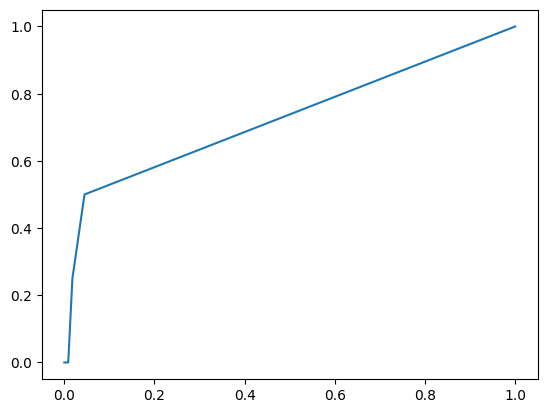

In [91]:

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')


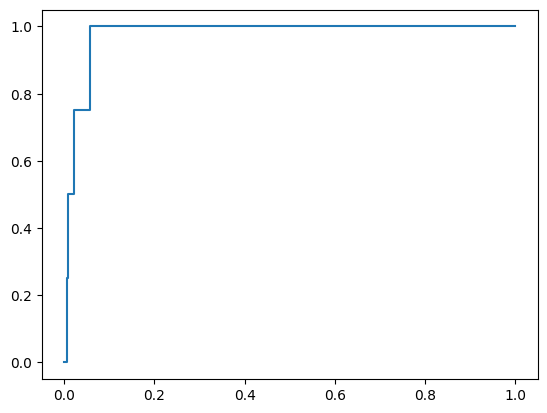

In [92]:

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')


In [93]:

# Isolation Forest doesn't have probabilities, so we'll skip its ROC curve

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Fraud Detection Models')
plt.legend(loc="lower right")
plt.savefig('roc_curves.png')
plt.close()


In [94]:

# Precision-Recall curves
plt.figure(figsize=(10, 8))


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

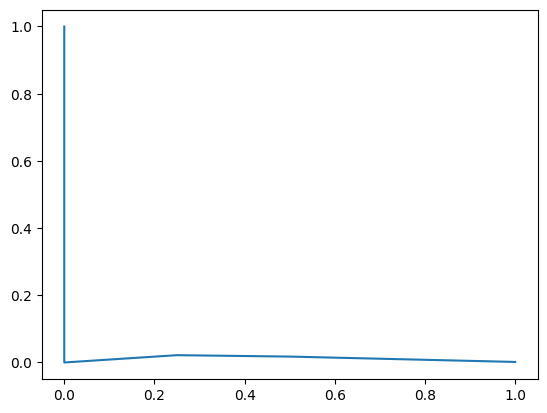

In [95]:

# Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
plt.plot(recall_rf, precision_rf, label='Random Forest')


In [96]:

# XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
plt.plot(recall_xgb, precision_xgb, label='XGBoost')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Fraud Detection Models')
plt.legend(loc="best")
plt.savefig('precision_recall_curves.png')
plt.close()


In [97]:

# Model comparison table
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Isolation Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_iso)
    ],
    'Precision': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_iso, output_dict=True)['1']['precision']
    ],
    'Recall': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_iso, output_dict=True)['1']['recall']
    ],
    'F1-Score': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_iso, output_dict=True)['1']['f1-score']
    ]
})

print(results.sort_values('F1-Score', ascending=False))
results.to_csv('model_comparison.csv', index=False)

              Model  Accuracy  Precision  Recall  F1-Score
2  Isolation Forest    0.9536   0.033333     1.0  0.064516
0     Random Forest    0.9984   0.000000     0.0  0.000000
1           XGBoost    0.9976   0.000000     0.0  0.000000


In [100]:
def predict_fraud(transaction_data, model_path='xgboost_model.pkl', scaler_path='scaler.pkl'):
    """
    Make fraud predictions on new transaction data.
    
    Args:
        transaction_data (dict): Dictionary with transaction features
        model_path (str): Path to the saved model
        scaler_path (str): Path to the saved scaler
        
    Returns:
        tuple: (prediction, probability)
    """
    # Load the model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    # Convert transaction data to DataFrame
    df = pd.DataFrame([transaction_data])
    
    # One-hot encode categorical features if needed
    if 'transaction_type' in df.columns:
        df = pd.get_dummies(df, columns=['transaction_type'], drop_first=True)
    
    # Fill missing columns that might be expected by the model
    for col in model.feature_names_in_:
        if col not in df.columns:
            df[col] = 0
    
    # Select only features used by the model
    df = df[model.feature_names_in_]
    
    # Scale features
    df_scaled = scaler.transform(df)
    
    # Make prediction
    prediction = model.predict(df_scaled)[0]
    probability = model.predict_proba(df_scaled)[0, 1]
    
    return prediction, probability


In [104]:

# Example usage
sample_transaction = {
    'amount': 15000,
    'balance_before': 20000,
    'time_of_day': 23,
    'day_of_week': 5,
    'transaction_type_Deposit': 0,
    'transaction_type_Transfer': 1,
    'transaction_type_Withdrawal': 0,
    'transaction_type_Bill Payment': 0,
    'transaction_type_Airtime': 0,
    'recipient_frequency': 1.2,
    'location_match': 0,
    'device_match': 1,
    'transaction_frequency': 8,
    'account_age_days': 450,
    'balance_after': 5000,
    'transaction_velocity': 6
}


In [106]:
def predict_fraud(transaction_data, model_path='xgboost_model.pkl', scaler_path='scaler.pkl'):
    """
    Make fraud predictions on new transaction data.
    
    Args:
        transaction_data (dict): Dictionary with transaction features
        model_path (str): Path to the saved model
        scaler_path (str): Path to the saved scaler
        
    Returns:
        tuple: (prediction, probability)
    """
    # Load the model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    # Convert transaction data to DataFrame
    df = pd.DataFrame([transaction_data])
    
    # Ensure all expected columns are present
    # This doesn't rely on feature_names_in_ which might not exist
    required_features = [
        'amount', 'balance_before', 'time_of_day', 'day_of_week',
        'recipient_frequency', 'location_match', 'device_match',
        'transaction_frequency', 'account_age_days', 'balance_after',
        'transaction_velocity'
    ]
    
    # Add transaction type columns if they exist in the data
    transaction_type_cols = [col for col in df.columns if col.startswith('transaction_type_')]
    all_features = required_features + transaction_type_cols
    
    # Ensure all columns needed are available
    for col in all_features:
        if col not in df.columns:
            df[col] = 0
    
    # Scale features
    df_scaled = scaler.transform(df[all_features])
    
    # Make prediction
    prediction = model.predict(df_scaled)[0]
    probability = model.predict_proba(df_scaled)[0, 1]
    
    return prediction, probability

In [108]:
import pickle

with open("xgboost_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)  # Ensure you use "rb"


In [109]:
import joblib

model = joblib.load("xgboost_model.pkl")  # Use joblib instead of pickle


In [110]:
import os

print(os.path.splitext("xgboost_model.pkl"))  # Should return (filename, '.pkl')


('xgboost_model', '.pkl')


In [111]:
import joblib

# Assuming you have the trained model
joblib.dump(model, "xgboost_model.pkl")
print("Model re-saved successfully.")


Model re-saved successfully.


In [112]:
model = joblib.load("xgboost_model.pkl")
print("Model loaded successfully.")


Model loaded successfully.


In [113]:
import joblib

model = joblib.load("xgboost_model.pkl")
print("Model loaded successfully.")


Model loaded successfully.


In [119]:
import joblib

model = joblib.load("xgboost_model.joblib")  # Load with the new name
print("Model loaded successfully.")


Model loaded successfully.


In [120]:
import joblib
from xgboost import XGBClassifier

# Train a sample model (replace with your actual trained model)
model = XGBClassifier()
model.fit([[0, 0], [1, 1]], [0, 1])  # Replace with actual training data

# Save it correctly using joblib
joblib.dump(model, "xgboost_model.joblib")

print("Model saved successfully!")


Model saved successfully!


In [123]:
df.columns = df.columns.astype(str)


In [124]:
if hasattr(model, "feature_names_in_"):
    df = df.reindex(columns=model.feature_names_in_, fill_value=0)
else:
    df = df  # Use the dataframe as it is


In [125]:
print(hasattr(model, "feature_names_in_"))  # Should return True


False


In [126]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Train model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# Check if feature names are now stored
print(hasattr(model, "feature_names_in_"))

True


In [128]:
print(type(X_train))  
print(X_train.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['amount', 'balance_before', 'time_of_day', 'day_of_week',
       'recipient_frequency', 'location_match', 'device_match',
       'transaction_frequency', 'account_age_days', 'balance_after',
       'transaction_velocity', 'transaction_type_Bill Payment',
       'transaction_type_Deposit', 'transaction_type_Transfer',
       'transaction_type_Withdrawal'],
      dtype='object')


In [129]:
X_train = pd.DataFrame(X_train, columns=X.columns)  # Ensure DataFrame format
X_test = pd.DataFrame(X_test, columns=X.columns)


In [130]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# Verify if feature names are now stored
print(hasattr(model, "feature_names_in_"))

True


In [131]:
X_test = X_test.reindex(columns=model.feature_names_in_, fill_value=0)


In [132]:
predictions = model.predict(X_test)


In [133]:

joblib.dump(model, "xgboost_model.joblib") 
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [134]:


# Load model
model = joblib.load("xgboost_model.joblib")

# Print feature names
print(model.feature_names_in_)


['amount' 'balance_before' 'time_of_day' 'day_of_week'
 'recipient_frequency' 'location_match' 'device_match'
 'transaction_frequency' 'account_age_days' 'balance_after'
 'transaction_velocity' 'transaction_type_Bill Payment'
 'transaction_type_Deposit' 'transaction_type_Transfer'
 'transaction_type_Withdrawal']


In [139]:
# Ensure all features exist and are in string format
df.columns = df.columns.astype(str)  # Convert all column names to string

missing_features = set(map(str, model.feature_names_in_)) - set(df.columns)
for feature in missing_features:
    df[feature] = 0  # Add missing features with default value

# Reorder columns to match model input
df = df[sorted(map(str, model.feature_names_in_))]

# Scale the input (Ensure it's a NumPy array)
df_scaled = scaler.transform(df.values)
